In [1]:
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format='retina'

# Description
This notebook demonstrates extraction of FX-adjusted discount curve from FX forwards and xccy quotes using `QuantLib`.

In this particular example, we will be building USD-collateralized-in-EUR curve (henceforth referred to as _modified USD curve_), given that we know:
- EUR discounting curve (based on €STR OIS rates),
- USD discounting curve (based on SOFR OIS rates),
- FX spot EURUSD,
- set of EURUSD FX forward quotes,
- set of xccy swaps which exchange (€STR + EUR spread) against SOFR.

The bootstrapping idea is that we find the USD discount curve that best replicates:
- FX forwards, taking fwd quotes, spot FX and EUR curve as given,
- xccy quotes (renders xccy swaps fair), taking EUR-leg spreads, keeping _forecasting_ EUR and USD curves, and EUR discounting as given. 

To keep things simple, we assume curves are flat. The FX fwd and xccy have been created ahead knowing a true modified USD curve.

Technically, the way the modified USD curve is built in `QuantLib`, is by first creating 'helpers' for both FX forwards (`ql.FxSwapRateHelper`) and xccy swaps (`CrossCurrencyBasisSwapRateHelper`) based on the market quotes, leaving the only degree of freedom in the modified USD discounting curve. Then we pass these helpers to `ql.Piecewise` to infer the modified discounting curve.

# Load inputs

In [2]:
date = ql.Date(18,8,2022)
ql.Settings.instance().evaluationDate = date

eur_rate = 0.01   # flat zero continuously compounded rate obtained from €STR OIS curve
usd_rate = 0.015  # flat zero continuously compounded rate obtained from SOFR OIS curve
spot_fx   = 1.2   # EURUSD (base currency = EUR)

fwd_quotes = pd.DataFrame({'expiry': ['1W', '1M', '3M', '6M', '9M', '12M'],
                           'fx_fwd': [1.200187, 1.2008, 1.202402, 1.20481, 1.207222, 1.209639]
                           })

xccy_quotes = pd.DataFrame({'expiry': ['2Y', '5Y', '10Y', '15Y', '20Y', '30Y'],
                            'EUR_spread':[-0.003014,-0.002981,-0.002926,-0.002871,-0.002819,-0.002721]
                            })

print('Fwd quotes:')
display(fwd_quotes)

print('xccy quotes:')
display(xccy_quotes)

Fwd quotes:


,expiry,fx_fwd
0,1W,1.200187
1,1M,1.200800
2,3M,1.202402
3,6M,1.204810
4,9M,1.207222
5,12M,1.209639


xccy quotes:


,expiry,EUR_spread
0,2Y,-0.003014
1,5Y,-0.002981
2,10Y,-0.002926
3,15Y,-0.002871
4,20Y,-0.002819
5,30Y,-0.002721


# Define €STR and SOFR flat curves

In [3]:
eur_curve = ql.YieldTermStructureHandle(
            ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(eur_rate)),ql.SimpleDayCounter()))
usd_curve = ql.YieldTermStructureHandle(
            ql.FlatForward(date, ql.QuoteHandle(ql.SimpleQuote(usd_rate)),ql.SimpleDayCounter()))

# Build FX forwards helpers

In [4]:
helpers_fwd = []
for tenor, fwd in fwd_quotes[['expiry', 'fx_fwd']].values:
    fwd_points = fwd - spot_fx
    helper = ql.FxSwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(fwd_points)), 
                                 ql.QuoteHandle(ql.SimpleQuote(spot_fx)), 
                                 ql.Period(tenor), 0, ql.NullCalendar(), 
                                 ql.Following, False, True, eur_curve)
    helpers_fwd.append(helper)

# Build xccy helpers

In [5]:
baseCurrencyIndex  = ql.Estr(eur_curve) # for forecasting EUR-leg cash-flow
quoteCurrencyIndex = ql.Sofr(usd_curve) # for forecasting USD-leg cash-flow

helpers_xccy = []
for tenor, eur_spread in xccy_quotes.values:
    basis  = ql.QuoteHandle(ql.SimpleQuote(eur_spread))
    helper = ql.CrossCurrencyBasisSwapRateHelper(basis, 
                                                 ql.Period(tenor), 0, 
                                                 ql.NullCalendar(), 
                                                 ql.ModifiedFollowing, True,
                                                 baseCurrencyIndex, 
                                                 quoteCurrencyIndex, 
                                                 eur_curve, True, True)
    helpers_xccy.append(helper)

# Bootstrap modified USD curve from the helpers

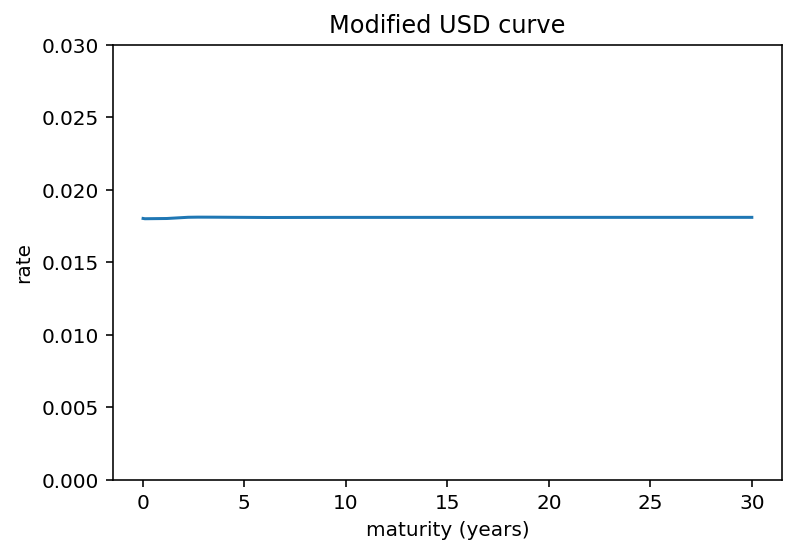

In [6]:
mod_usd_curve = ql.PiecewiseLogCubicDiscount(0,ql.NullCalendar(),
                                            helpers_fwd + helpers_xccy,
                                            ql.SimpleDayCounter())

times = np.linspace(0.01, 30, 1000)
mod_usd_rates = [mod_usd_curve.zeroRate(t, ql.Continuous).rate() for t in times]

fig, ax = plt.subplots()
ax.plot(times, mod_usd_rates)
ax.set_ylim([0, 0.03]);
ax.set_title('Modified USD curve');
ax.set_xlabel('maturity (years)');
ax.set_ylabel('rate');